# Import

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import os

import package_DBR
import PACKAGE_LAB

from importlib import reload
package_DBR = reload(package_DBR)
PACKAGE_LAB = reload(PACKAGE_LAB)

from package_DBR import *
from PACKAGE_LAB import *


from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os


# Simulation Parameters

In [2]:
TSim = 2600   
Ts = 1                      
N = int(TSim/Ts) + 1
# Working point
MV0 = 50
DV0 = 50
PV0 = 52.5             


# Parameters Step response MV : A verifier
Kp = 0.407
T1p =   150.245
T2p =  2.754
thetap =  6

# Parameters Step response DV
Kd =   0.22940157900053862
T1d =    235.05979493875853
T2d =   4.990264278507082
thetad =    50.462409314789745

# Process object
P = Process({})
P.parameters['kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0

# Parameters PID controller
gamma = 0.6                                             
Kc, Ti, Td = IMC_TUNING(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print("Kc : ", Kc )
print("Ti : ", Ti )
print("Td : ", Td )

alpha = 1
#La puissance de chauffe est limité entre 0 et 100 %
MVMin = 0  
MVMax = 100

Kc :  3.9098351370185123
Ti :  152.999
Td :  2.7044276759978825


# 4 scénariosn de simulation

In [3]:
scenario = "CLP+FF"

# Scenario 1 : OLP + no FF  
if scenario == "OLP+noFF":
    ManPath = {0:True, TSim: True} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0:PV0, TSim: PV0}   
    DVPath = {0: 50.0, 1100: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True

    
# Scenaro 2 : OLP + FF
elif scenario == "OLP+FF":
    ManPath = {0:True, TSim: True} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0:PV0, TSim: PV0}  
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True

# Scenaro 3 : CLP + no FF
elif scenario == "CLP+noFF":
    ManPath = {0:True, 500:False, TSim: False} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10} 
    ActivateFF = False
    ManFF = False

# Scenaro 4 : CLP + FF
elif scenario == "CLP+FF":
    ManPath = {0:True, 500:False, TSim: False} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10} 
    ActivateFF = True
    ManFF = False

# Discrete-time PID controller with feedforward structure on actual TCLab system

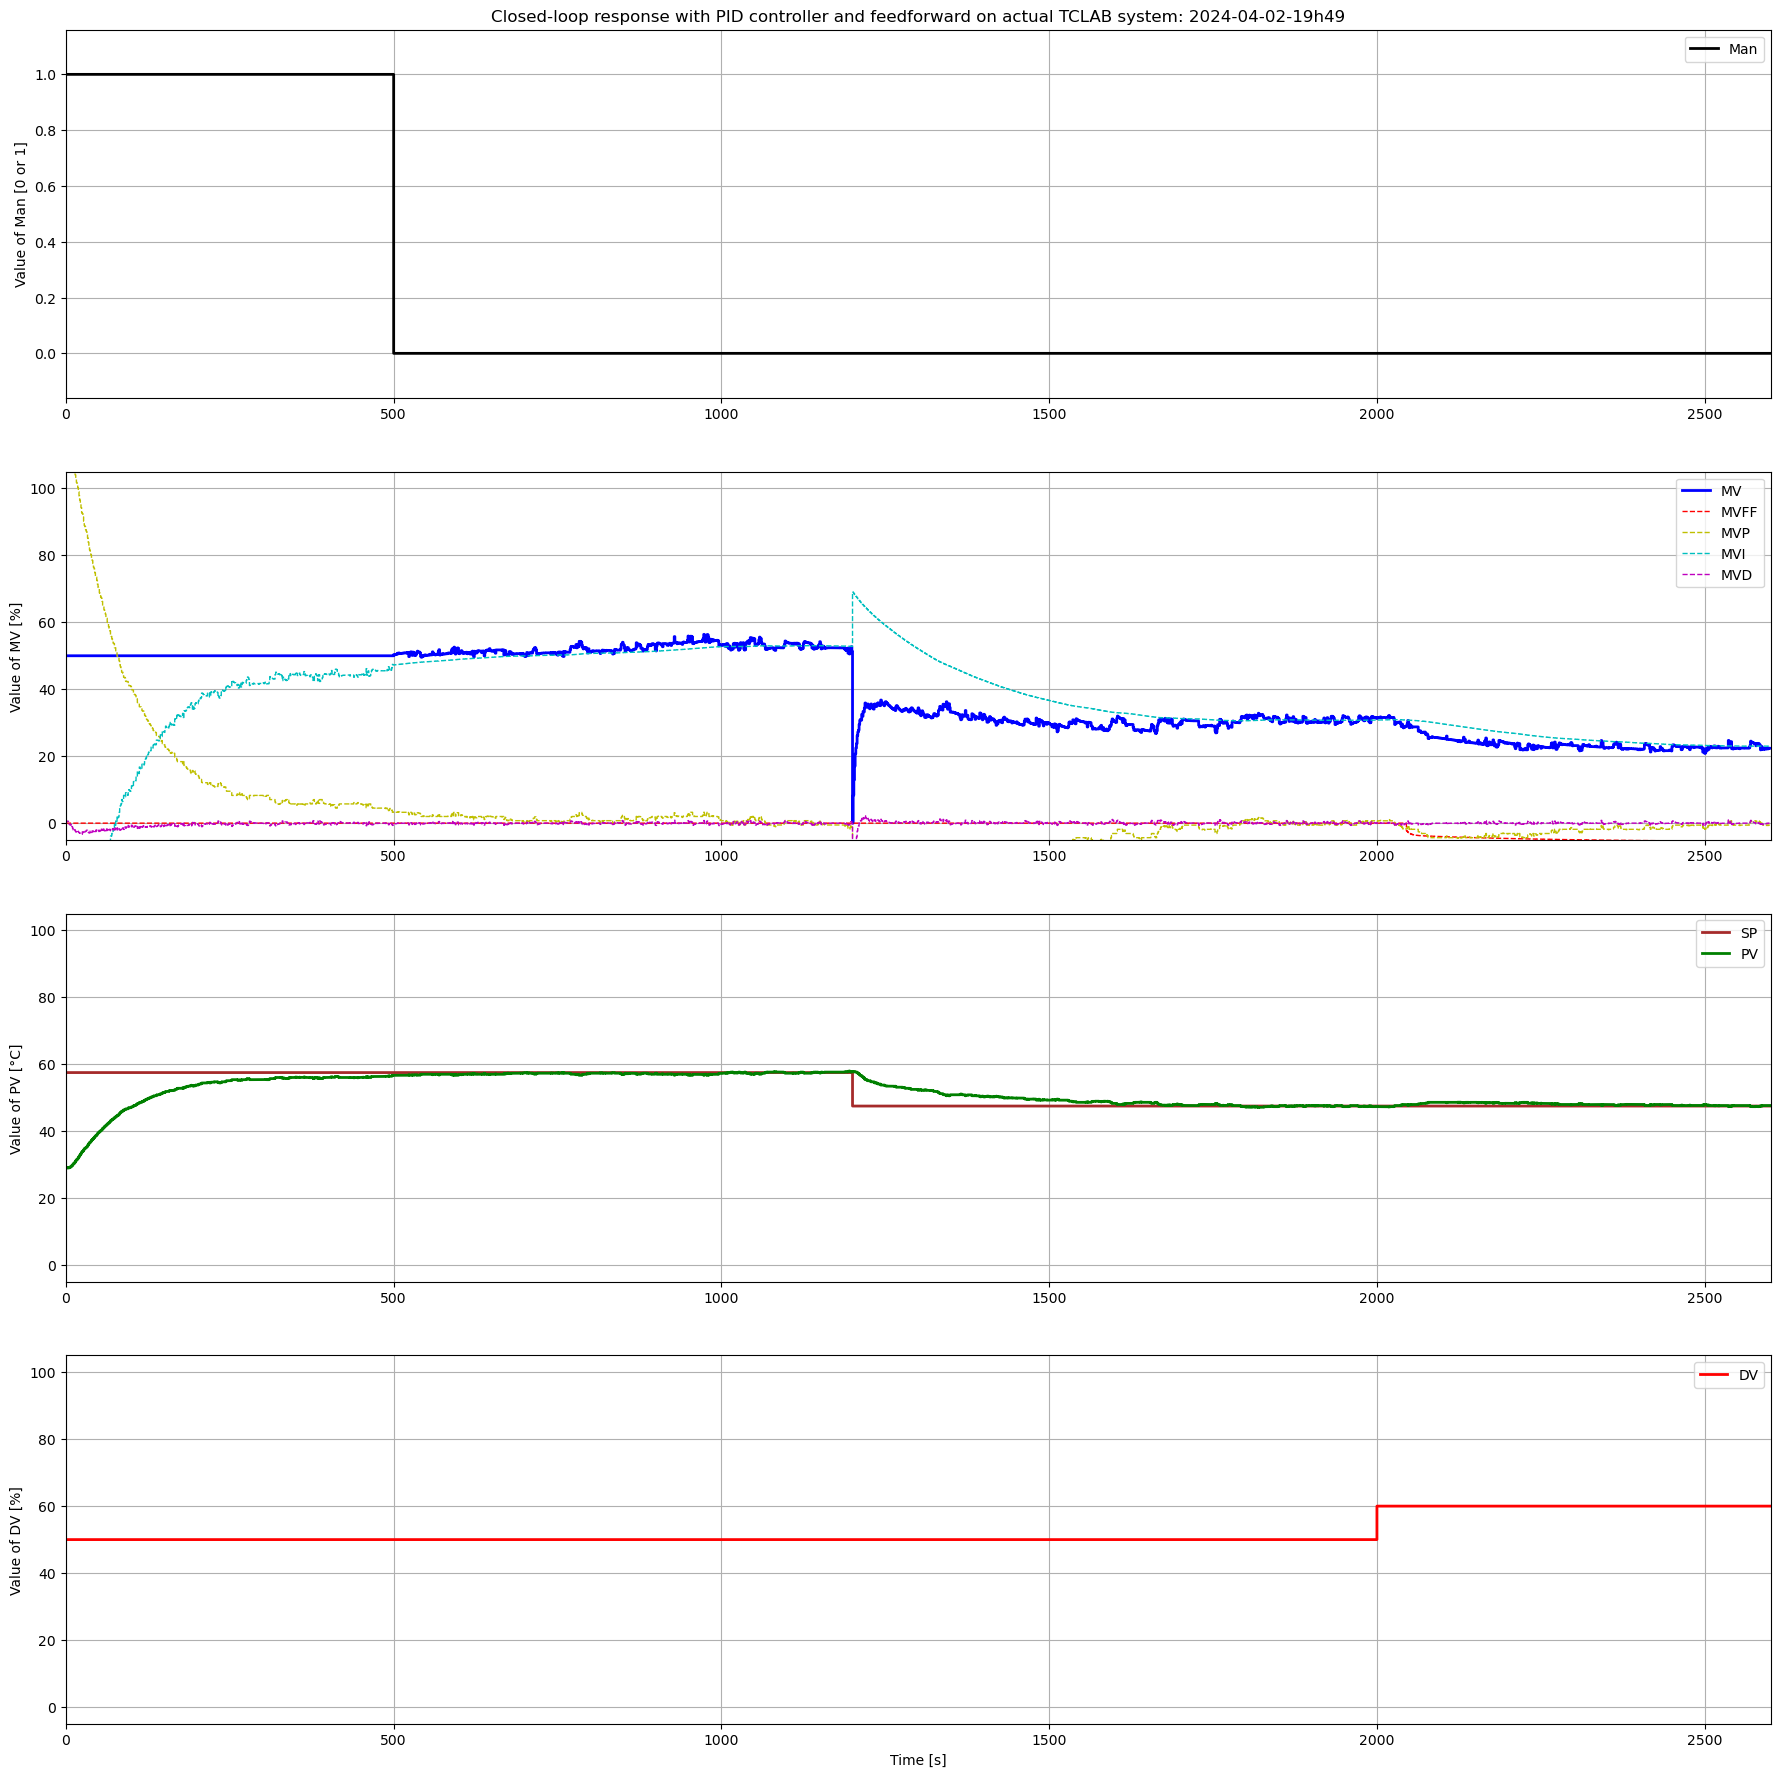

TCLab disconnected successfully.


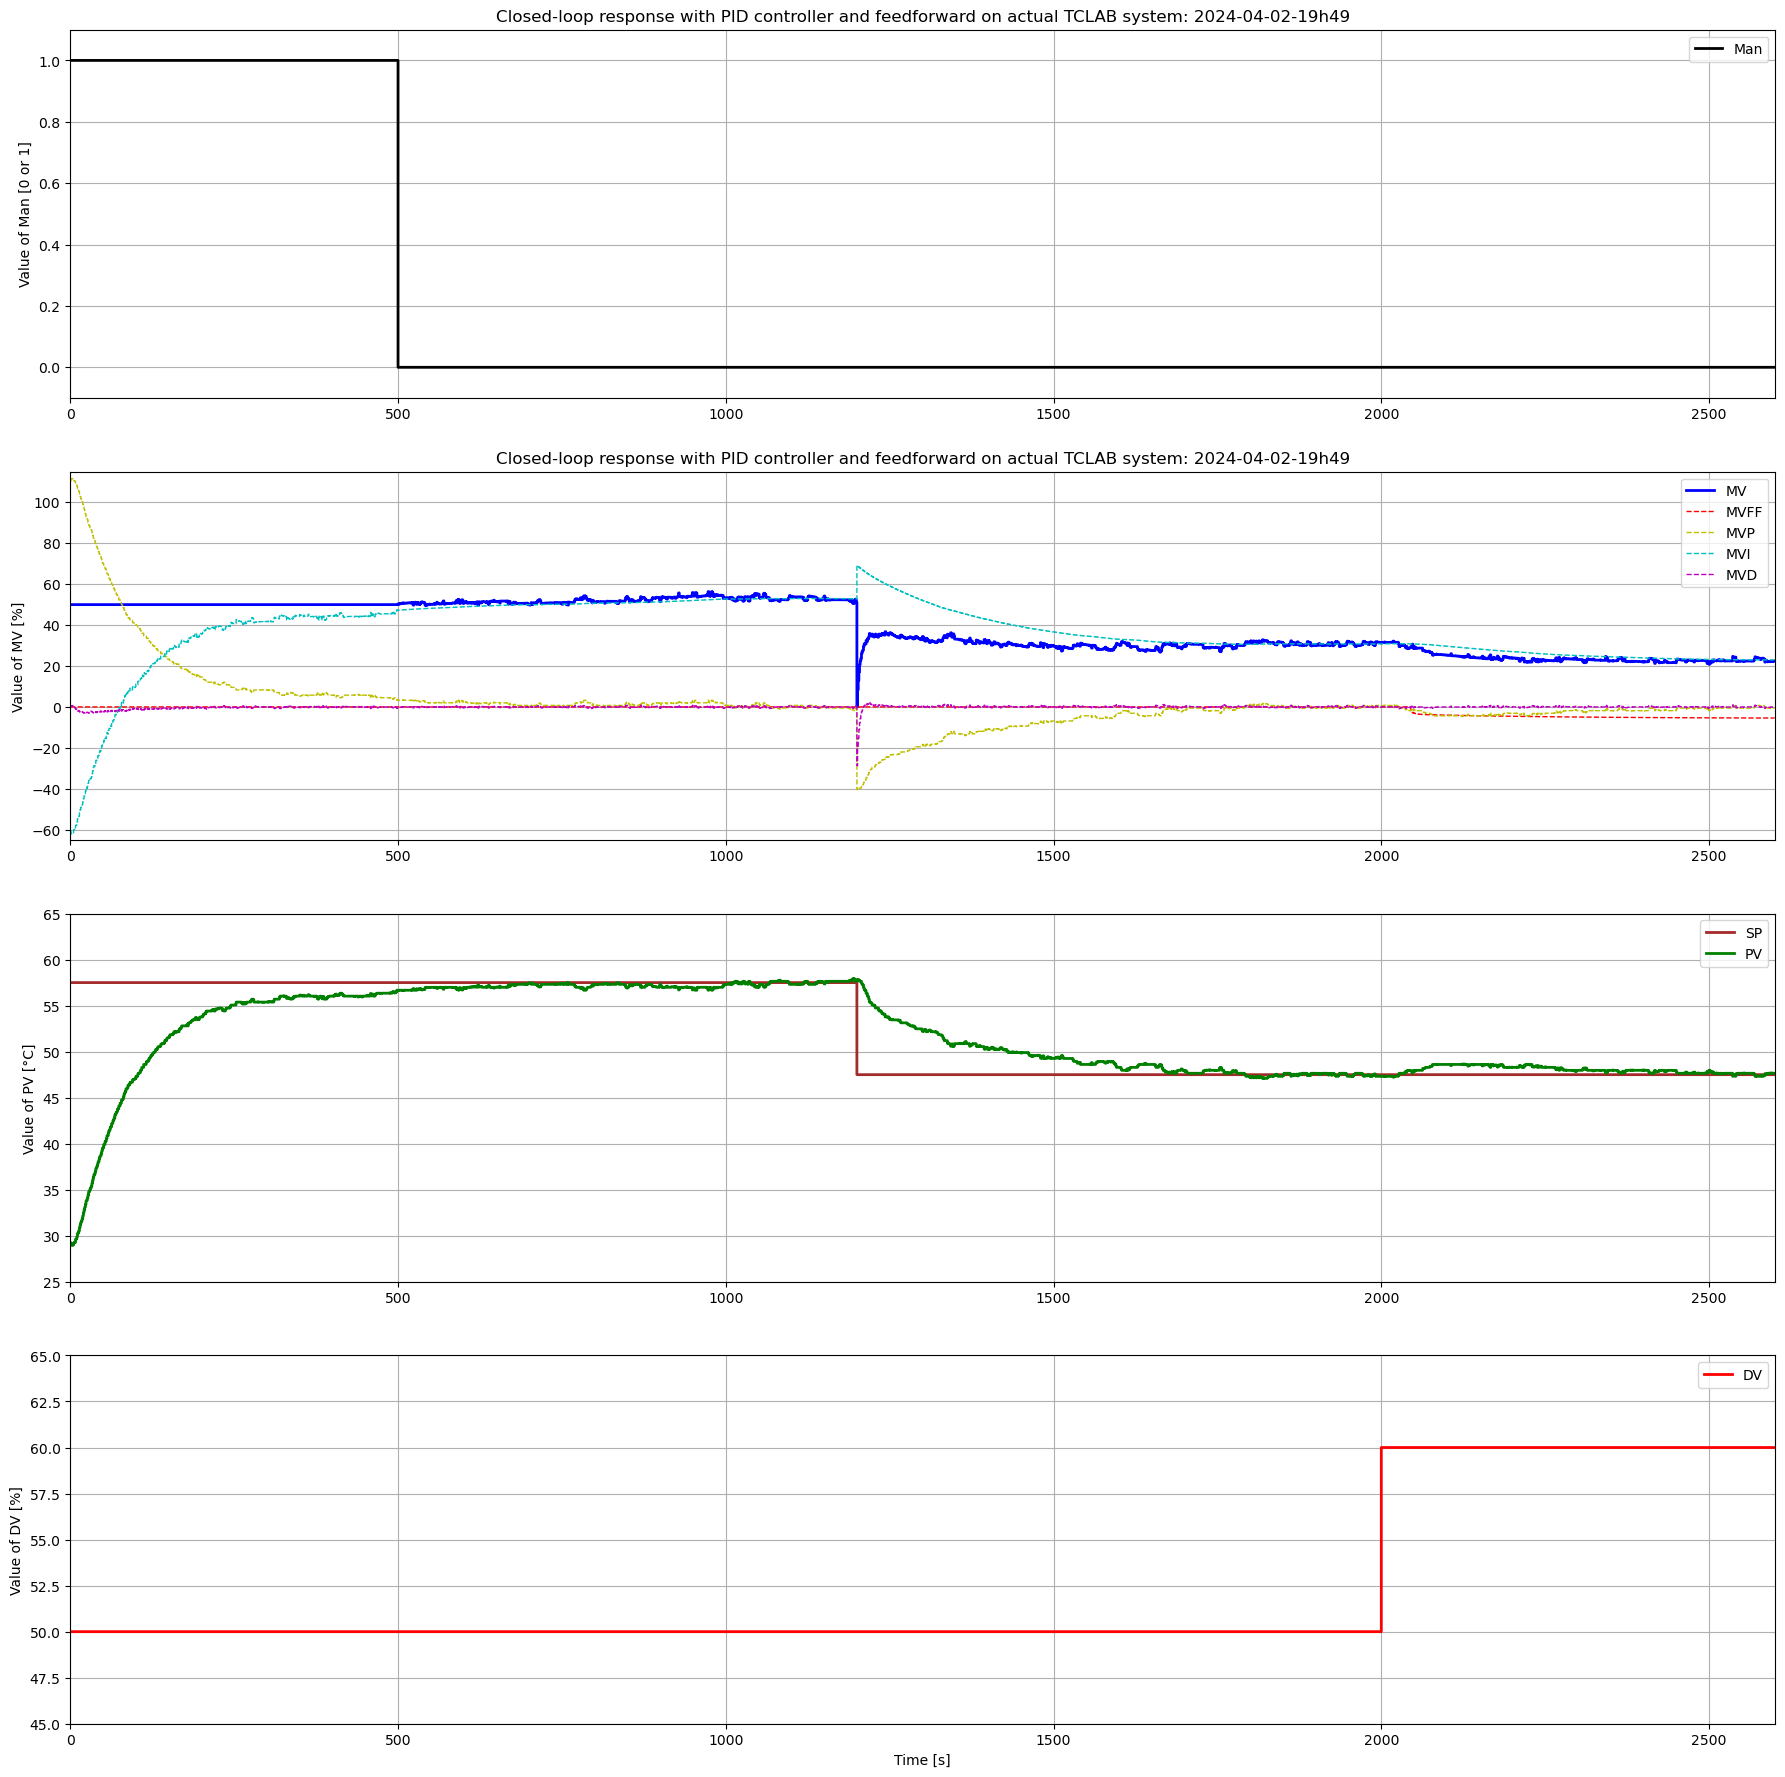

In [4]:
# Initialisation 
t = []

SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MV_FF_Delay = []
MV_FF_LL1 = []

lab = tclab.TCLab()

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[-0.1,1.1],'k-',linewidth=2,label="Man",where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward on actual TCLAB system: ' + date_time)
ax1.legend(loc='best')
ax1.grid(True)

l2, = ax2.step([0,TSim],[0,100],'b-',linewidth=2,label="MV",where='post')
l9, = ax2.step([0,TSim],[0,100],'--r',linewidth=1,label="MVFF",where='post')
l3, = ax2.step([0,TSim],[0,100],'--y',linewidth=1,label="MVP",where='post')
l4, = ax2.step([0,TSim],[0,100],'--c',linewidth=1,label="MVI",where='post')
l5, = ax2.step([0,TSim],[0,100],'--m',linewidth=1,label="MVD",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')
ax2.grid(True)

l6, = ax3.step([0,TSim],[0,100],'brown',linewidth=2,label="SP",where='post')
l7, = ax3.step([0,TSim],[0,100],'g-',linewidth=2,label="PV",where='post')
ax3.set_ylabel("Value of PV [°C]")
ax3.legend(loc='best')
ax3.grid(True)

l8, = ax4.step([0,TSim],[0,100],'r-',linewidth=2,label="DV",where='post')
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')
ax4.grid(True)


for i in range(0,N):
    t.append(i*Ts)
    
    # Process Value
    PV.append(lab.T1)
    
    # Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # Apply DV
    lab.Q2(DV[-1])
    
    # Feedforward  -->   probléme avec le ff encore a résoudre
    Delay_RT( DV - DV0*np.ones_like(DV), np.max([thetad-thetap,0]) , Ts , MV_FF_Delay )
    LL_RT( MV_FF_Delay , -Kd/Kp, T1p, T1d, Ts, MV_FF_LL1)   
    if ActivateFF:
        LL_RT(MV_FF_LL1 , 1 , T2p , T2d ,Ts,MVFF)         
    else:
        LL_RT(MV_FF_LL1,0,T2p,T2d,Ts,MVFF)
        
    # PID 
    PID_RT( SP , PV , Man , MVMan, MVFF,Kc, Ti,Td, alpha ,Ts , MVMin , MVMax , MV , MVP , MVI , MVD,E, ManFF)
    
    # pour MV
    lab.Q1(MV[-1])
    
    # Pour Ts
    time.sleep(Ts)    
    l1.set_data( t, Man)    
    l2.set_data( t, MV)
    l3.set_data( t , MVP)
    l4.set_data( t, MVI)
    l5.set_data( t , MVD)    
    l6.set_data( t , SP)
    l7.set_data( t , PV)   
    l8.set_data( t , DV)
    l9.set_data( t , MVFF)
    
    clear_output(wait=True)
    
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    display(fig)

lab.close()

ax1.set_ylim(-0.1,1.1)
ax2.set_title( 'Closed-loop response with PID controller and feedforward on actual TCLAB system: ' +  date_time )
ax2.set_ylim( myRound(np.min(( np.min(MV) , np.min(MVP) , np.min(MVI) , np.min(MVD) , np.min(MVFF) )) , 5 ) -5 , myRound(np.max(( np.max(MV), np.max(MVP) , np.max(MVI) , np.max(MVD) , np.max(MVFF) )), 5 ) +5 )
ax3.set_ylim( myRound(np.min(( np.min(PV) , np.min(SP) ) ) , 5 ) - 5, myRound( np.max(( np.max(PV) , np.max(SP) )) , 5) +5 )
ax4.set_ylim( myRound(np.min(DV) , 5 ) -5 , myRound(np.max(DV) , 5 ) +5 )

nameFile = 'Plots/Closed_loop_experiment3_with_PID_and_FF_' + scenario
plt.savefig(nameFile + '.png',transparent= True)            
plt.savefig(nameFile + '.pdf',transparent=True)            


t = np.array( t )
MV = np.array( MV )
MVP = np.array( MVP )             
MVI = np.array( MVI )             
MVD = np.array( MVD )    
MVFF = np.array( MVFF ) 
SP = np.array( SP ) 
PV = np.array( PV ) 
DV = np.array( DV )   
Man = np.array( Man) 
my_data = np.vstack(( t.T , MV.T , MVP.T , MVI.T , MVD.T , MVFF.T , SP.T , PV.T , DV.T , Man.T ))
my_data = my_data.T
nameFile = 'Data/Experiment_'+ scenario + '.txt'
np.savetxt( nameFile , my_data , delimiter = ',', header = ' t , MV , MVP , MVI , MVD , MVFF , SP , PV , DV , Man' , comments = '' )



